### Imports & Display Options

In [1]:
%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 100

In [2]:
from matplotlib import pylab

In [3]:
import numpy as np
import feather
import re
from datetime import datetime
from itertools import cycle

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

In [5]:
from keras.utils import np_utils
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Dense, GlobalMaxPooling1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Sequential, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.regularizers import l2
from keras.callbacks import TensorBoard, Callback
from keras.metrics import top_k_categorical_accuracy

Using TensorFlow backend.


### Import Data & Clean

In [ ]:
df = pd.read_csv('./BasicCompanyDataAsOneFile-2018-03-01.csv')
df.head()

In [ ]:
def clean(df):
    wdf = df.dropna(subset=['Returns.LastMadeUpDate'])
    wdf = wdf[['CompanyName', 'SICCode.SicText_1']]
    wdf['CompanyName'] = wdf.CompanyName.str.replace('[".,()\-\']', ' ')\
        .str.replace('\s+', ' ').str.strip()\
        .str.replace('LIMITED', 'LTD')\
        .str.replace('INCORPORATED', 'INC')\
        .str.replace('([A-Z])LTD', '\\1 LTD')\
        .str.replace('(LTD|INC|PLC)', '')\
        .str.replace('\\b[A-Z0-9]\\b', '')
    wdf['SICC'] = SICC = wdf['SICCode.SicText_1'].str.split(' - ').str[0]
    wdf = wdf[(SICC != '74990') & (SICC != '99999') & (SICC != '7499') & SICC.str.isnumeric()]
    wdf = wdf[wdf.CompanyName.str.count(' ') < 8]
    return wdf

In [ ]:
wdf = clean(df)
len(wdf)

### Remove Unknown Names

In [34]:
wdf['WordSum'] = wdf.CompanyName.str.replace('[0-9]', '').apply(sum_of_custom_tokenize)
(wdf.WordSum == 0).sum()

2310

In [35]:
# Remove super short names
(wdf.CompanyName.str.len() < 4).sum()

0

In [36]:
wdf[wdf.WordSum == 0].head(25)

,CompanyName,SICC,WordSum,Industry,SICText,OrigIndustry
313,006 PUBCO,56302,0,563,56302 - Public houses and bars,563
454,12 DOLLSHOUSES,47650,0,476,47650 - Retail sale of games and toys in speci...,476
1184,16 MINIBUSES/MVL,49390,0,493,49390 - Other passenger land transport,493
1276,40 WAMLA,98000,0,980,98000 - Residents property management,980
1813,10 THE WALDRONS,98000,0,980,98000 - Residents property management,980
1961,100 BODYCARE,96090,0,9609,96090 - Other service activities n.e.c.,960
1963,100 BROADST,68209,0,682,68209 - Other letting and operating of own or ...,682
2224,101 ROKFORM,41202,0,412,41202 - Construction of domestic buildings,412
2578,1066 ROLLERDANCE,93290,0,932,93290 - Other amusement and recreation activit...,932
2598,107 FORTUNESWELL,68209,0,682,68209 - Other letting and operating of own or ...,682


In [37]:
wdf = wdf[(wdf.WordSum > 0) & (wdf.CompanyName.str.len() > 3) & (wdf.SICC.str.len() == 5)]
len(wdf)

2110207

In [22]:
# Remove company names that are all numbers
wdf = wdf[~wdf.CompanyName.str.match('^[0-9\\s]+$')]
len(wdf)

### Feature Engineering

In [ ]:
wdf['Industry'] = wdf['SICCode.SicText_1'].str.split(' - ').str[0].str[0:3]
wdf['SICText'] = wdf['SICCode.SicText_1']
wdf = wdf.drop('SICCode.SicText_1', axis=1)
wdf.head()

In [15]:
# Copy industry column, as it will be modified
wdf['OrigIndustry'] = wdf['Industry']

In [47]:
hard_to_classify_set = {"829", "479", "960", "329", "461", "464", "639", "289", "642", "661"}
def merge_split_classes(value):
    if value[:3] in hard_to_classify_set:
        return value[:4]
    else:
        return value[:3]

In [48]:
# Split some hard to classify classes out
wdf['Industry'] = wdf.SICC.apply(merge_split_classes)

In [49]:
# These class is not possible to predict, a bunch of misc.
wdf = wdf[wdf.Industry != '8299']  # Other business activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.Industry != '9609']  # Other service activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.Industry != '4618']  # Sales of other products
print(len(wdf))
wdf = wdf[wdf.Industry != '4619']  # Sales of variety of goods
print(len(wdf))
wdf = wdf[wdf.Industry != '559']  # Other accomodations
print(len(wdf))
wdf = wdf[wdf.Industry != '332']  # Industrial machinery
print(len(wdf))
wdf = wdf[wdf.Industry != '682']  # Renting and leasing real estate
print(len(wdf))
wdf = wdf[wdf.SICC != '74909']   # Other professional, scientific, technical activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.SICC != '79909']   # Other reservation service activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.SICC != '63990']   # Other infomation service activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.SICC != '47990']   # Other retail sales
print(len(wdf))
wdf = wdf[wdf.SICC != '68209']   # Other letting operating real estate (n.e.c)
print(len(wdf))
wdf = wdf[wdf.SICC != '66190']   # Activities auxiliary financial intermediation (n.e.c)
print(len(wdf))

1588631
1588631
1588631
1585597
1585597
1585597
1581209
1581209
1581209
1581209
1581209
1581209
1581209


### Check for Class Imbalance

In [10]:
def plot_frequency(df, feature, top=50):
    classes = df.groupby([feature]).CompanyName.count().sort_values(ascending=False)
    print('AVG: ', classes.mean())
    return classes.head(top).plot(kind='bar', figsize=(10, 3))

In [ ]:
plot_frequency(wdf, 'Industry')

In [ ]:
plot_frequency(wdf, 'SICText')

In [21]:
min_class_count = 2500
classes = wdf.groupby(['Industry']).count().sort_values('CompanyName', ascending=False)
print(' Classes below %s samples: %s/%s' % (min_class_count, (classes.CompanyName < min_class_count).sum(), len(classes.CompanyName)))

 Classes below 2500 samples: 0/107


In [22]:
classes[classes.CompanyName < min_class_count].head()

,CompanyName,SICC,WordSum,SICText,OrigIndustry
Industry,,,,,


In [23]:
classes[classes.CompanyName < min_class_count].sum()

CompanyName     0.0
SICC            0.0
WordSum         0.0
SICText         0.0
OrigIndustry    0.0
dtype: float64

In [ ]:
# Remove classes with low count
to_replace = classes[classes.CompanyName < min_class_count].index
wdf['Industry'] = wdf['Industry'].replace(to_replace, '0')
# Remove unknown data
wdf = wdf[wdf['Industry'] != '0']
len(wdf)

### Resample Data

AVG:  14358.126126126126


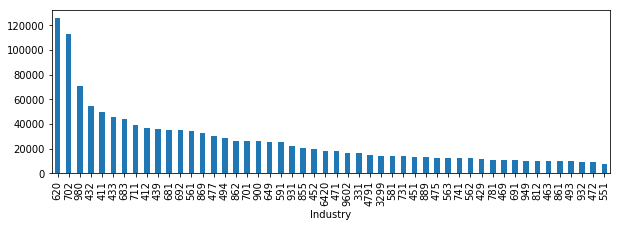

In [51]:
plot_frequency(wdf, 'Industry')

AVG:  4464.291316526611


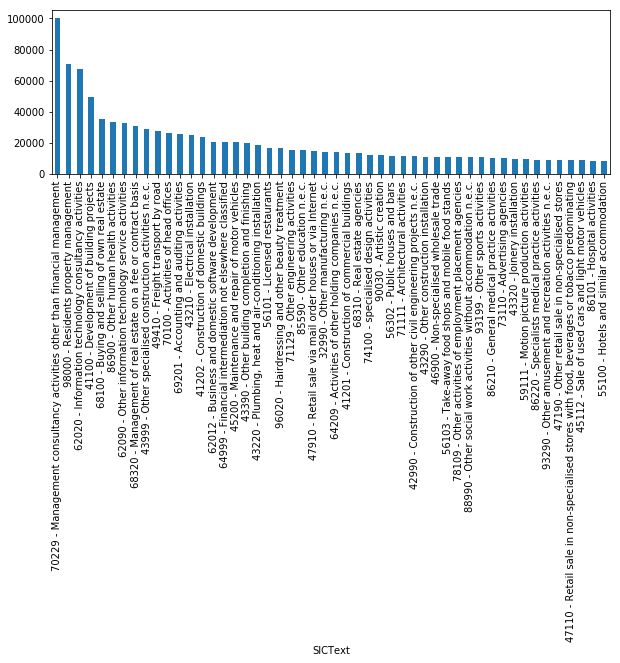

In [52]:
plot_frequency(wdf, 'SICText')

In [7]:
def resample_classes(df, groupby, samples):
    classes = wdf.groupby([groupby]).CompanyName.count()
    freqs = dict(samples/classes)
    freq = df[groupby].map(freqs)
    np.random.seed(42)
    criteria = np.random.rand(len(df)) < freq
    return df[criteria]

In [8]:
rwdf = resample_classes(wdf, 'Industry', 6500)

AVG:  5476.409523809524


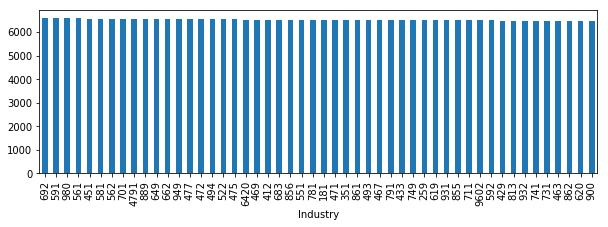

In [11]:
plot_frequency(rwdf, 'Industry')

AVG:  1642.922857142857


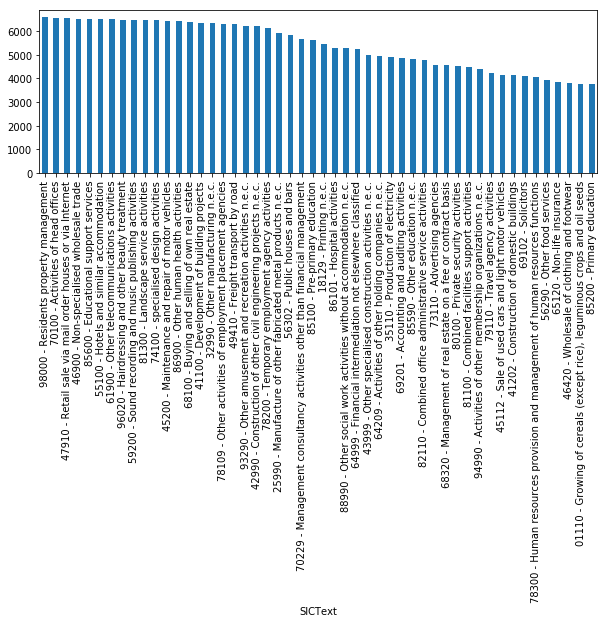

In [12]:
plot_frequency(rwdf, 'SICText')

### Pickle Working Set

In [54]:
feather.write_dataframe(wdf, 'wdf4m-no-num-nec.feather')

In [6]:
wdf = feather.read_dataframe('wdf4m-no-num-nec.feather')
wdf.head()

,CompanyName,SICC,WordSum,Industry,SICText,OrigIndustry
0,!NVERTD DESIGNS,58190,5089,581,58190 - Other publishing activities,581
1,!OBAC UK,70229,2046,702,70229 - Management consultancy activities othe...,702
2,!YOZO FASS,90010,349123,900,90010 - Performing arts,900
3,243 RUGBY ROAD MANAGEMENT COMPANY,98000,4265,980,98000 - Residents property management,980
4,309 WEST END LANE MANAGEMENT,98000,5476,980,98000 - Residents property management,980


### Label Encoding

In [271]:
industry_encoder = LabelEncoder()
industry_encoder.fit(rwdf['Industry'])
encoded_industry = industry_encoder.transform(rwdf['Industry'])
industry_labels = np_utils.to_categorical(encoded_industry)
industry_labels.shape

(575023, 105)

In [272]:
num_industries = industry_labels.shape[1]

### Text Encoding

In [15]:
def load_glove_embeddings(fp, embedding_dim, include_empty_char=True):
    """
    Loads pre-trained word embeddings (GloVe embeddings)
        Inputs: - fp: filepath of pre-trained glove embeddings
                - embedding_dim: dimension of each vector embedding
                - generate_matrix: whether to generate an embedding matrix
        Outputs:
                - word2coefs: Dictionary. Word to its corresponding coefficients
                - word2index: Dictionary. Word to word-index
                - embedding_matrix: Embedding matrix for Keras Embedding layer
    """
    # First, build the "word2coefs" and "word2index"
    word2coefs = {} # word to its corresponding coefficients
    word2index = {} # word to word-index
    with open(fp) as f:
        for idx, line in enumerate(f):
            try:
                data = [x.strip().lower() for x in line.split()]
                word = data[0]
                coefs = np.asarray(data[1:embedding_dim+1], dtype='float32')
                word2coefs[word] = coefs
                if word not in word2index:
                    word2index[word] = len(word2index)
            except Exception as e:
                print('Exception occurred in `load_glove_embeddings`:', e)
                continue
        # End of for loop.
    # End of with open
    if include_empty_char:
        word2index[''] = len(word2index)
    # Second, build the "embedding_matrix"
    # Words not found in embedding index will be all-zeros. Hence, the "+1".
    vocab_size = len(word2coefs)+1 if include_empty_char else len(word2coefs)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2index.items():
        embedding_vec = word2coefs.get(word)
        if embedding_vec is not None and embedding_vec.shape[0]==embedding_dim:
            embedding_matrix[idx] = np.asarray(embedding_vec)
    # return word2coefs, word2index, embedding_matrix
    return word2index, np.asarray(embedding_matrix)

In [16]:
word2index, embedding_matrix = load_glove_embeddings('glove.6B/glove.6B.200d.txt', embedding_dim=200)

In [11]:
def custom_tokenize(d):
    return [word2index.get(re.sub(r'[^\w\s]','',w).lower(), 0) for w in d.split()]

In [265]:
def custom_tokenize2(d):
    tokens = []
    words = d.split()
    for word in words:
        word = re.sub(r'[^\w\s]','',word).lower()
        if word in word2index:
            tokens.append(word2index[word])
        else:
            tokens = tokens + [word2index.get(w, 0) for w in split_compound_words(word, word2index)]
    return tokens

def split_compound_words(word, corpus):
    result = [word]
    word = word.strip('0123456789')
    min_score = 2e5
    max_threshold = 2e4
    min_threshold = 100
    for x in range(1, len(word)+1):
        head, tail = word[:x], word[x:]
        head_score = corpus.get(head, 2e5/2) + max(0, -len(head)*20000 + 60000)
        tail_score = corpus.get(tail, 2e5/2) + max(0, -len(tail)*20000 + 60000)
        if (min_threshold < head_score < max_threshold or
            min_threshold < tail_score < max_threshold):
            if (head_score + tail_score) < min_score:
                result = [head, tail]
                min_score = head_score + tail_score
    return result

In [266]:
print(split_compound_words('communitech', word2index))
print(split_compound_words('biceppower', word2index))
print(split_compound_words('appleworks', word2index))
print(split_compound_words('tmobile', word2index))
print(split_compound_words('northstar', word2index))
print(split_compound_words('griscware', word2index))
print(split_compound_words('windmobile', word2index))
print(split_compound_words('dreamworks', word2index))

['communi', 'tech']
['bicep', 'power']
['apple', 'works']
['t', 'mobile']
['north', 'star']
['grisc', 'ware']
['wind', 'mobile']
['dream', 'works']


In [267]:
def sum_of_custom_tokenize(d):
    return sum(word2index.get(re.sub(r'[^\w\s]','',w).lower(), 0) for w in d.split())

In [268]:
vocab_size, embedding_dim = embedding_matrix.shape
maxlen = 10
print(custom_tokenize2('Rhinoshield'))
print(custom_tokenize2('21039'))
print(custom_tokenize2('what is this, an apple ltd?'))
vocab_size, embedding_dim

[21921, 5728]
[0]
[102, 14, 37, 29, 3292, 8196]


(400001, 200)

In [269]:
encoded_company_names = [custom_tokenize2(d) for d in rwdf.CompanyName]
encoded_company_names = [d for d in encoded_company_names]
encoded_company_names = pad_sequences(encoded_company_names, maxlen=maxlen, padding='post')

In [273]:
# Sanity check
len(encoded_company_names), len(industry_labels)

(575023, 575023)

### Train/Test Split

In [274]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_company_names, industry_labels, test_size=0.12, random_state=42)
y_train.shape

(506020, 105)

### Model

In [282]:
weight_decay = 1e-4
num_filters = 128
n2 = 256
n3 = 128
pool_size = 2
window_size = 3
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,
                            weights=[embedding_matrix], trainable=False)
top3 = lambda x, y: top_k_categorical_accuracy(x, y, k=3)
top3.__name__ = 'top3'

model = Sequential()
model.add(embedding_layer)
model.add(Convolution1D(num_filters, window_size, activation='relu', padding='same'))
#model.add(MaxPooling1D(pool_size))
model.add(Convolution1D(num_filters, window_size, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
# model.add(Dense(n2, activation='relu', kernel_regularizer=l2(weight_decay)))
# model.add(Dropout(0.2))
model.add(Dense(n3, activation='relu', kernel_regularizer=l2(weight_decay)))
# model.add(Dropout(0.2))
model.add(Dense(num_industries, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', top3])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 200)           80000200  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 10, 128)           76928     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 10, 128)           49280     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 105)               13545     
Total para

### ROC AUC Metric

In [283]:
class ROCCallback(Callback):
    def __init__(self,training_data,validation_data):
        self.x, self.y = training_data
        self.x_val, self.y_val = validation_data

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

### Hook up Tensorboard

`tensorboard --logdir='tmp'`

In [286]:
date_suffix = str(datetime.now()).replace(':', '-').split('.')[0]
temp_folder = 'tmp/GloVe%s-fd%s-industry-resmpl-cnn3x%s-%s-gpool-nnec-%s' % (
    embedding_dim, num_industries, num_filters, n3, date_suffix)
temp_folder

'tmp/GloVe200-fd105-industry-resmpl-cnn3x128-128-gpool-nnec-2018-03-28 15-06-17'

### Train Model

In [287]:
callbacks = [TensorBoard(log_dir=temp_folder)]
#callbacks.append(ROCCallback((X_train, y_train), (X_test, y_test)))
model.fit(
    X_train, y_train, epochs=18, batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=callbacks)

Train on 506020 samples, validate on 69003 samples
Epoch 1/18
506020/506020 [==============================] - 68s 135us/step - loss: 3.1942 - acc: 0.2511 - top3: 0.4343 - val_loss: 2.8715 - val_acc: 0.3160 - val_top3: 0.5109
Epoch 2/18
506020/506020 [==============================] - 67s 132us/step - loss: 2.9589 - acc: 0.2997 - top3: 0.4916 - val_loss: 2.8237 - val_acc: 0.3251 - val_top3: 0.5213
Epoch 3/18
506020/506020 [==============================] - 67s 133us/step - loss: 2.9061 - acc: 0.3090 - top3: 0.5021 - val_loss: 2.8164 - val_acc: 0.3281 - val_top3: 0.5264
Epoch 4/18
506020/506020 [==============================] - 67s 132us/step - loss: 2.8758 - acc: 0.3146 - top3: 0.5092 - val_loss: 2.7988 - val_acc: 0.3345 - val_top3: 0.5300
Epoch 5/18
506020/506020 [==============================] - 64s 127us/step - loss: 2.8567 - acc: 0.3188 - top3: 0.5135 - val_loss: 2.7893 - val_acc: 0.3348 - val_top3: 0.5322
Epoch 6/18
506020/506020 [==============================] - 67s 133us/step

### Testing/Validation

In [289]:
loss, accuracy, top3 = model.evaluate(X_test, y_test)
accuracy

69003/69003 [==============================] - 5s 68us/step


0.34272422938305885

In [292]:
y_labels = np.argmax(y_test, axis=1)
y_pred = model.predict_classes(X_test)
y_labels.shape, y_pred.shape
y_scores = model.predict(X_test)
cm = confusion_matrix(y_pred, y_labels)

In [293]:
print('Verifying accuracy', (y_labels==y_pred).sum()/len(y_pred))

Verifying accuracy 0.342724229381


In [294]:
def plot_confusion_matrix(cm, encoder):
    pylab.figure(figsize=(18,18))
    cm = cm/cm.sum(axis=0)
    dim, _ =cm.shape
    pylab.matshow(cm, fignum=False, cmap='Blues', vmin=0, vmax=0.5)
    ax = pylab.gca()
    ax.set_xticks(range(dim))
    ax.set_xticklabels(encoder.inverse_transform(pd.Series(range(dim))), rotation='vertical')
    ax.set_yticks(range(dim))
    ax.set_yticklabels(encoder.inverse_transform(pd.Series(range(dim))))
    pylab.colorbar()
    pylab.grid(False)
    pylab.xlabel('Predicted')
    pylab.ylabel('Actual')
    pylab.show()

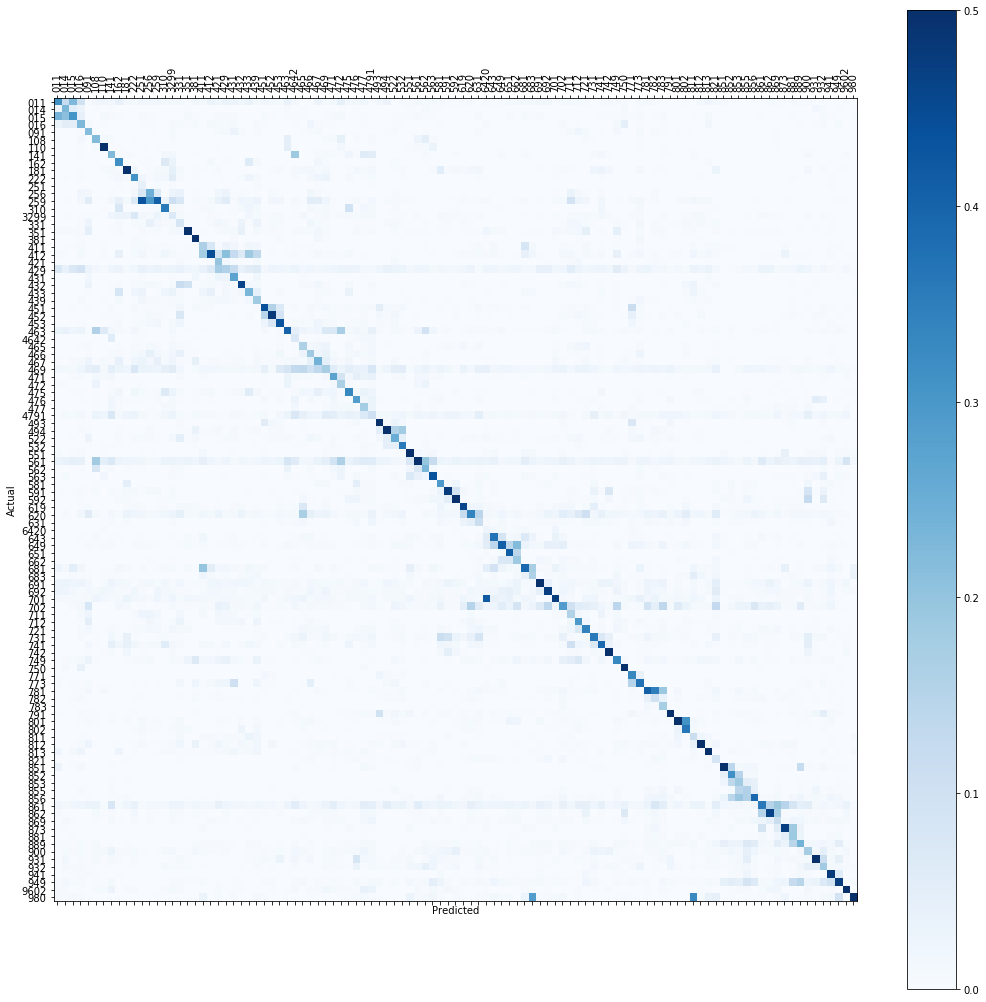

In [295]:
plot_confusion_matrix(cm, industry_encoder)

In [296]:
def acc_per_class(cm, encoder):
    cm_scaled = cm/cm.sum(axis=0)
    acc = pd.Series(np.diag(cm_scaled))
    acc = acc.reset_index()
    acc['acc'] = acc[0]
    acc['class'] = encoder.inverse_transform(acc.index)
    acc['total'] = cm.sum(axis=0)
    return acc[['class', 'acc', 'total']].set_index('class').sort_values('acc', ascending=False)

In [297]:
acc_per_class(cm, industry_encoder)

,acc,total
class,,
980,0.853189,831
851,0.676737,662
791,0.656325,838
110,0.632716,324
9602,0.628788,792
351,0.615193,803
812,0.604087,783
691,0.583001,753
750,0.580475,379


### ROC Evaluation

In [74]:
def plot_roc(y_test, y_score, encoder):
    # Compute ROC curve and area for each class
    print('ROC AUC Score: %s' % roc_auc_score(y_test, y_score))
    lw = 2
    n_classes = y_test.shape[1]
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = pylab.subplots()
    fig.set_figwidth(12)
    fig.set_figheight(8)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'crimson', 'navy',
                    'darksalmon', 'cadetblue', 'deeppink', 'darkolivegreen', 'fuchsia'])
    sorted_classes = sorted(range(n_classes), key=lambda i: roc_auc[i])
    for i, color in zip(sorted_classes, colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(encoder.inverse_transform(i), roc_auc[i]))
    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    pylab.xlim([0.0, 1.0])
    pylab.ylim([0.0, 1.05])
    pylab.xlabel('False Positive Rate')
    pylab.ylabel('True Positive Rate')
    ax.legend(loc="lower left", bbox_to_anchor=(0.0, 1.01), ncol=4, frameon=False)
    pylab.show()

ROC AUC Score: 0.887781513744


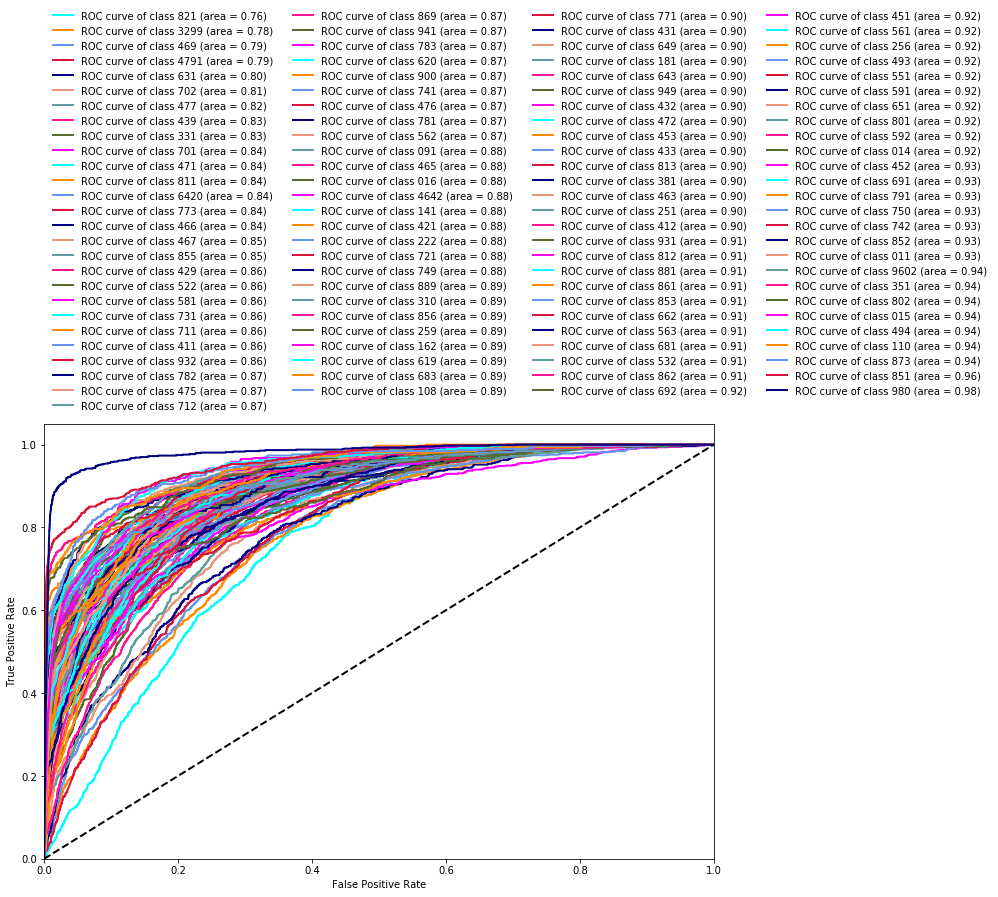

In [75]:
plot_roc(y_test, y_scores, industry_encoder)

### Test with Original Sampling

In [8]:
industry_encoder = LabelEncoder()
industry_encoder.fit(wdf['Industry'])
encoded_industry = industry_encoder.transform(wdf['Industry'])
industry_labels = np_utils.to_categorical(encoded_industry)
industry_labels.shape

(1581209, 105)

In [17]:
encoded_company_names = [custom_tokenize(d) for d in wdf.CompanyName]
encoded_company_names = [d for d in encoded_company_names]
encoded_company_names = pad_sequences(encoded_company_names, maxlen=maxlen, padding='post')

In [18]:
# Sanity check
len(encoded_company_names), len(industry_labels)

(1581209, 1581209)

In [19]:
y_pred_score = model.predict(encoded_company_names)

In [21]:
industry_labels.shape, y_pred_score.shape

((1581209, 105), (1581209, 105))

In [20]:
# Top K accuracy
print('Top1: %s' % top_k_categorical_accuracy(industry_labels, y_pred_score, k=1))
print('Top3: %s' % top_k_categorical_accuracy(industry_labels, y_pred_score, k=3))
print('Top5: %s' % top_k_categorical_accuracy(industry_labels, y_pred_score, k=5))

Top1: Tensor("Mean:0", shape=(), dtype=float32)
Top3: Tensor("Mean_1:0", shape=(), dtype=float32)
Top5: Tensor("Mean_2:0", shape=(), dtype=float32)


In [ ]:
loss, accuracy = model.evaluate(encoded_company_names, industry_labels)
accuracy

In [ ]:
y_labels = np.argmax(y_test, axis=1)
y_pred = model.predict_classes(encoded_company_names)
y_labels.shape, y_pred.shape
cm = confusion_matrix(y_pred, y_labels)

In [ ]:
plot_confusion_matrix(cm, [])

In [ ]:
acc_per_class(cm, industry_encoder)

### Save/Load Model

In [291]:
model_output = 'models/%s-acc%0.4f.h5' % ('Trial12-GloVe200-Stacked-4m-CNN-Pooled-No-NEC-Compound', accuracy)
model.save(model_output)
model_output

'models/Trial12-GloVe200-Stacked-4m-CNN-Pooled-No-NEC-Compound-acc0.3427.h5'

In [6]:
model = load_model('models/Trial10-GloVe100-Stacked-4m-CNN-Pooled-No-NEC-acc0.3378.h5')

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


### Play with Model

In [77]:
SIC_df = pd.read_csv('SIC07_CH_condensed_list_en.csv', dtype={'SIC Code': 'object'})

In [78]:
def pretext(precode):
    return '\n'.join('\t\t%s\t%s' % (value['SIC Code'], value.Description[:90]) 
                     for i, value in SIC_df[SIC_df['SIC Code'].str.startswith(precode)].iterrows())

In [ ]:
while True:
    name = input()
    if not name:
        break
    name = re.sub(r"[\-,'\"]", " ", name)
    encoded = custom_tokenize(name)
    if sum(encoded) == 0:
        print('\tWords in the input are not recognized.')
        continue
    encoded_company_name = pad_sequences([encoded], maxlen=maxlen, padding='post')
    pred = model.predict(encoded_company_name).flatten()
    probas = sorted(enumerate(pred), key=lambda x: x[1], reverse=True)[:3]
    total = sum(pred)
    if max(pred)/total < 0.1:
        print('\tNo classification exceeds 10% likelihood.')
        continue
    for i, p in probas:
        code = industry_encoder.inverse_transform(i)
        print('\t%0.2f%%' % (p/total*100))
        print(pretext(code))